In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.figure_4 import plot_figure_4

from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code.utils.decay_common import calc_decays, calc_halflives, calc_decay_windows, _halflife
from jtb_2022_code import FigureSingleCellData
from inferelator_velocity import decay

import inferelator_velocity as ifv

import numpy as np
import pandas as pd

/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/cj59/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [3]:
## LOAD AND PROCESS VELOCITY AND DECAY ###
data = FigureSingleCellData()
data.load_pseudotime(do_rho=False)

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
data.decay_data_all()

AnnData object with n_obs × n_vars = 173347 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'program_0_time', 'program_1_time'
    var: 'n_cells', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'leiden', 'programs', 'cell_cycle_decay', 'cell_cycle_decay_se', 'cell_cycle_alpha', 'rapamycin_decay', 'rapamycin_decay_se', 'rapamycin_alpha'
    uns: 'cell_cycle_decay', 'cell_cycle_window_decay', 'log1p', 'neighbors', 'pca', 'programs', 'rapamycin_decay', 'rapamycin_window_decay', 'umap'
    obsm: 'X_pca', 'X_umap', 'cellrank_False', 'cellrank_True', 'dpt_False', 'dpt_True', 'monocle_False', 'monocle_True', 'palantir_False', 'palantir_True'
    varm: 'PCs', 'cell_cycle_window_alpha', 'cell_cycle_window_decay', 'cell_cycle_window_decay_se', 'rapamycin_window_alpha', 'rapamycin_window_decay', 'rapamycin_window_decay_se'
    layers: 'counts',

In [5]:
data.expt_data[(1, "WT")]

AnnData object with n_obs × n_vars = 63533 × 5747
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'n_genes', 'CC', 'RP', 'RiBi', 'iESR', 'Mito', 'Cell Cycle', 'Other', 'Pool_Combined', 'program_0_time', 'program_1_time', 'program_rapa_time', 'program_cc_time', 'dpt_pt', 'cellrank_pt', 'monocle_pt', 'palantir_pt'
    var: 'n_cells', 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'Cell Cycle', 'Other', 'category', 'programs'
    uns: 'log1p', 'neighbors', 'noise2self', 'pca', 'program_0_pca', 'program_1_pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'program_0_pca', 'program_1_pca', 'dpt_False', 'cellrank_False', 'monocle_False', 'palantir_False', 'dpt_True', 'cellrank_True', 'monocle_True', 'palantir_True'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'noise2self_distance_graph'

In [4]:
import gc
import numpy as np

if 'rapamycin_window_decay' not in data.expt_data[(2, "fpr1")].varm:
    for k in data.expts:
        _decay = data.decay_data(*k)

        for vark in ['rapamycin_window_decay', 'cell_cycle_window_decay']:
            data.expt_data[k].varm[vark] = _decay.varm[vark]
            data.expt_data[k].varm[vark + "_se"] = _decay.varm[vark + "_se"]
            data.expt_data[k].uns[vark] = _decay.uns[vark]
            
        for vark in ['rapamycin_decay', 'rapamycin_decay_se', 'cell_cycle_decay', 'cell_cycle_decay_se']:
            data.expt_data[k].var[vark] = _decay.var[vark].copy()
            
        _idx = [_decay.var_names.get_loc(x) for x in FIGURE_4_GENES]
        
        data.expt_data[k].obsm['FIG4_EXPR'] = _decay.X[:, _idx]
        data.expt_data[k].obsm[f'FIG4_{RAPA_VELO_LAYER}'] = _decay.layers[RAPA_VELO_LAYER][:, _idx]
        data.expt_data[k].obsm[f'FIG4_{CC_VELO_LAYER}'] = _decay.layers[CC_VELO_LAYER][:, _idx]

        del _decay
        gc.collect()
        
    data.decay_data_all()

Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_1_fpr1.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_WT.h5ad
Loading velocity data from /scratch/cj59/RAPA/2021_RAPA_VELOCITY_FIGS_2_fpr1.h5ad


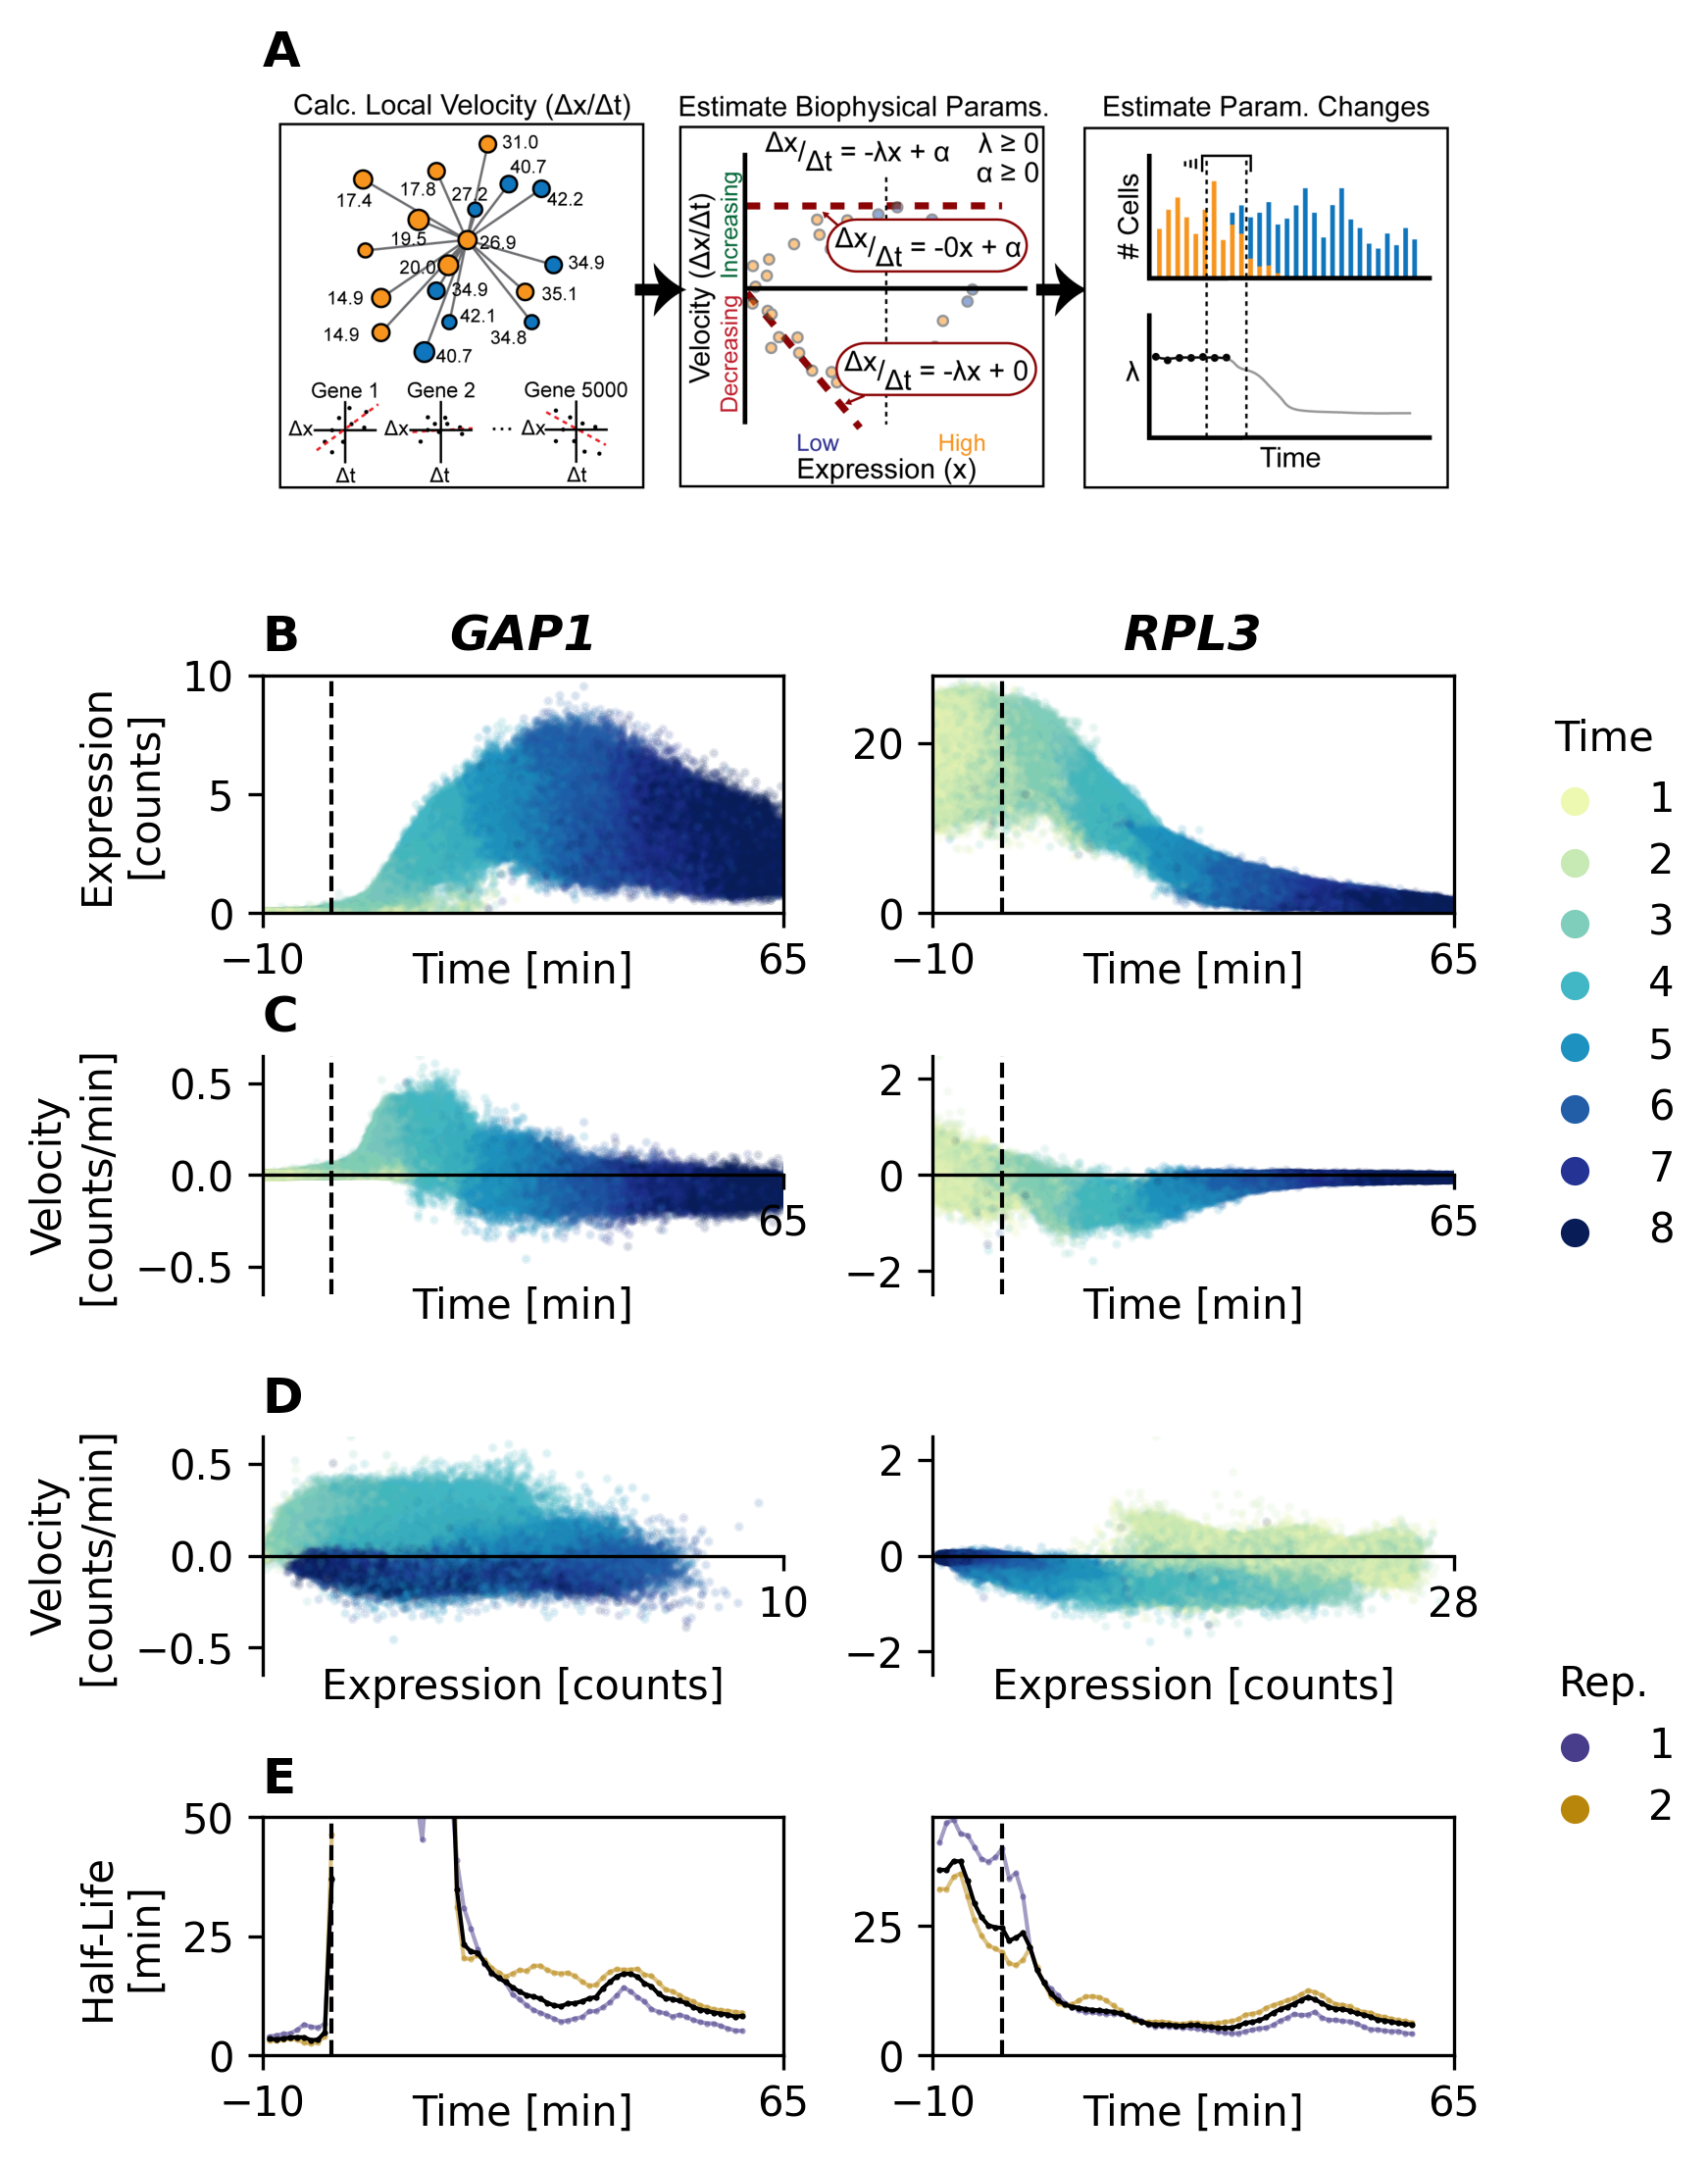

In [5]:
fig = plot_figure_4(data)